# Heart Disease Prediction Dataset - DSA Project
This notebook demonstrates the use of Data Structures and Algorithms (DSA) on the Heart Disease Dataset from Kaggle. We will perform data preprocessing, searching, sorting, and extract insights to identify key factors contributing to heart disease.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import heapq
import random

# Set visualization style
plt.style.use('ggplot')
sns.set_palette('Set2')

# Load the dataset
df = pd.read_csv('heart.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Dataset Information

The Heart Disease dataset contains the following features:

- **age**: Age in years
- **sex**: Sex (1 = male, 0 = female)
- **cp**: Chest pain type (0-3)
  - 0: Typical angina
  - 1: Atypical angina
  - 2: Non-anginal pain
  - 3: Asymptomatic
- **trestbps**: Resting blood pressure (in mm Hg)
- **chol**: Serum cholesterol in mg/dl
- **fbs**: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- **restecg**: Resting electrocardiographic results (0-2)
  - 0: Normal
  - 1: Having ST-T wave abnormality
  - 2: Showing probable or definite left ventricular hypertrophy
- **thalach**: Maximum heart rate achieved
- **exang**: Exercise induced angina (1 = yes; 0 = no)
- **oldpeak**: ST depression induced by exercise relative to rest
- **slope**: The slope of the peak exercise ST segment (0-2)
  - 0: Upsloping
  - 1: Flat
  - 2: Downsloping
- **ca**: Number of major vessels (0-4) colored by fluoroscopy
- **thal**: Thalassemia (0-3)
  - 0: Normal
  - 1: Fixed defect
  - 2: Reversible defect
  - 3: Unknown
- **target**: Heart disease (1 = present; 0 = absent)

## Data Preprocessing

In [47]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
df.describe().T

Missing values in each column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Basic statistics:


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


In [48]:
# Reset the dataframe to start fresh
# Load the dataset again
df = pd.read_csv('heart.csv')

# Add patient IDs for demonstration purposes
df['patient_id'] = [f'P{i:04d}' for i in range(1, len(df) + 1)]

# Create a copy of the dataframe for our algorithms
heart_data = df.copy()

# Create a weighted risk score BEFORE converting to categorical
# This is a simplified risk score based on medical knowledge
heart_data['risk_score'] = (
    (heart_data['age'] > 50).astype(int) * 2 +  # Age > 50 adds 2 points
    (heart_data['chol'] > 240).astype(int) * 3 +  # High cholesterol adds 3 points
    (heart_data['trestbps'] > 140).astype(int) * 2 +  # High blood pressure adds 2 points
    (heart_data['thalach'] < 120).astype(int) * 2 +  # Low max heart rate adds 2 points
    (heart_data['exang'] == 1).astype(int) * 3 +  # Exercise-induced angina adds 3 points
    (heart_data['oldpeak'] > 2).astype(int) * 2 +  # ST depression > 2 adds 2 points
    (heart_data['ca'] > 0).astype(int) * 3  # Colored vessels add 3 points
)

# NOW encode categorical variables AFTER calculating risk score
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for col in categorical_cols:
    heart_data[col] = heart_data[col].astype('category')

# Display the first few rows with the new columns
heart_data[['patient_id', 'age', 'sex', 'chol', 'trestbps', 'risk_score', 'target']].head(10)

,patient_id,age,sex,chol,trestbps,risk_score,target
0,P0001,52,1,212,125,5,0
1,P0002,53,1,203,140,7,0
2,P0003,70,1,174,145,9,0
3,P0004,61,1,203,148,7,0
4,P0005,62,0,294,138,10,0
5,P0006,58,0,248,100,5,1
6,P0007,58,1,318,114,10,0
7,P0008,55,1,289,160,13,0
8,P0009,46,1,249,120,3,0
9,P0010,54,1,286,122,15,0


## 1. Searching Algorithms

### 1.1 Linear Search Implementation

In [49]:
def linear_search(data, criteria):
    """
    Perform a linear search on the dataset based on multiple criteria.
    
    Parameters:
    - data: DataFrame containing the dataset
    - criteria: Dictionary with column names as keys and target values as values
    
    Returns:
    - DataFrame with matching rows
    """
    start_time = time.time()
    
    # Initialize with all True
    mask = pd.Series([True] * len(data))
    
    # Apply each criterion
    for column, value in criteria.items():
        mask = mask & (data[column] == value)
    
    result = data[mask]
    end_time = time.time()
    
    print(f"Linear search completed in {(end_time - start_time) * 1000:.4f} ms")
    print(f"Found {len(result)} matching records")
    
    return result

# Example: Find all male patients with chest pain type 2 and target=1
search_criteria = {'sex': 1, 'cp': 2, 'target': 1}
linear_search_result = linear_search(heart_data, search_criteria)
linear_search_result.head()

Linear search completed in 3.0019 ms
Found 114 matching records


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,patient_id,risk_score
19,58,1,2,140,211,1,0,165,0,0.0,2,0,2,1,P0020,2
26,44,1,2,130,233,0,1,179,1,0.4,2,0,2,1,P0027,3
34,50,1,2,129,196,0,1,163,0,0.0,2,0,2,1,P0035,0
41,54,1,2,120,258,0,0,147,0,0.4,1,0,3,1,P0042,5
52,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1,P0053,3


### 1.2 Binary Search Implementation

In [50]:
def binary_search(data, column, target):
    """
    Perform binary search on a sorted dataset for a specific value.
    
    Parameters:
    - data: DataFrame containing the dataset
    - column: Column name to search in
    - target: Value to search for
    
    Returns:
    - Index of the found item or -1 if not found
    """
    # Sort the data by the specified column
    start_time = time.time()
    data_sorted = data.sort_values(column).reset_index(drop=True)
    
    low, high = 0, len(data_sorted) - 1
    found_idx = -1
    
    # Binary search algorithm
    while low <= high:
        mid = (low + high) // 2
        if data_sorted.loc[mid, column] == target:
            found_idx = mid
            break
        elif data_sorted.loc[mid, column] < target:
            low = mid + 1
        else:
            high = mid - 1
    
    end_time = time.time()
    print(f"Binary search completed in {(end_time - start_time) * 1000:.4f} ms")
    
    if found_idx != -1:
        print(f"Found target {target} in column '{column}' at index {found_idx}")
        return data_sorted.loc[found_idx]
    else:
        print(f"Target {target} not found in column '{column}'")
        return None

# Example: Search for a patient with cholesterol = 250
binary_search_result = binary_search(heart_data, 'chol', 250)
binary_search_result

Binary search completed in 0.9992 ms
Found target 250 in column 'chol' at index 592


age              55
sex               0
cp                1
trestbps        135
chol            250
fbs               0
restecg           0
thalach         161
exang             0
oldpeak         1.4
slope             1
ca                0
thal              2
target            1
patient_id    P0730
risk_score        5
Name: 592, dtype: object

### 1.3 Hash Table Implementation (O(1) Lookup)

In [51]:
class PatientHashTable:
    """
    A hash table implementation for O(1) patient lookup by ID.
    """
    def __init__(self, data, id_column='patient_id'):
        self.hash_table = {}
        self.id_column = id_column
        self.build_hash_table(data)
    
    def build_hash_table(self, data):
        """
        Build the hash table from the DataFrame.
        """
        start_time = time.time()
        for idx, row in data.iterrows():
            patient_id = row[self.id_column]
            self.hash_table[patient_id] = row.to_dict()
        end_time = time.time()
        print(f"Hash table built in {(end_time - start_time) * 1000:.4f} ms")
        print(f"Hash table contains {len(self.hash_table)} entries")
    
    def lookup(self, patient_id):
        """
        Look up a patient by ID in O(1) time.
        """
        start_time = time.time()
        result = self.hash_table.get(patient_id, None)
        end_time = time.time()
        
        print(f"Hash table lookup completed in {(end_time - start_time) * 1000:.4f} ms")
        return result

# Create a hash table for our patient data
patient_hash_table = PatientHashTable(heart_data)

# Look up a patient by ID
patient_id_to_find = 'P0010'  # 10th patient
found_patient = patient_hash_table.lookup(patient_id_to_find)

if found_patient:
    print(f"\nPatient {patient_id_to_find} details:")
    for key, value in found_patient.items():
        if key in ['age', 'sex', 'cp', 'trestbps', 'chol', 'target', 'risk_score']:
            print(f"{key}: {value}")
else:
    print(f"Patient {patient_id_to_find} not found")

Hash table built in 40.0128 ms
Hash table contains 1025 entries
Hash table lookup completed in 0.0000 ms

Patient P0010 details:
age: 54
sex: 1
cp: 0
trestbps: 122
chol: 286
target: 0
risk_score: 15


## 2. Sorting Algorithms

### 2.1 Merge Sort Implementation

In [52]:
def merge_sort(arr, key=lambda x: x):
    """
    Implementation of the Merge Sort algorithm.
    Time Complexity: O(n log n)
    Space Complexity: O(n)
    
    Parameters:
    - arr: List to be sorted
    - key: Function to extract comparison key
    
    Returns:
    - Sorted list
    """
    if len(arr) <= 1:
        return arr
    
    # Divide the array into two halves
    mid = len(arr) // 2
    left = arr[:mid]
    right = arr[mid:]
    
    # Recursively sort both halves
    left = merge_sort(left, key)
    right = merge_sort(right, key)
    
    # Merge the sorted halves
    return merge(left, right, key)

def merge(left, right, key):
    """
    Merge two sorted lists into a single sorted list.
    """
    result = []
    i = j = 0
    
    # Compare elements from both lists and add the smaller one to the result
    while i < len(left) and j < len(right):
        if key(left[i]) <= key(right[j]):
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1
    
    # Add any remaining elements
    result.extend(left[i:])
    result.extend(right[j:])
    
    return result

# Example: Sort patients by age using Merge Sort
# Convert DataFrame to list of dictionaries for our sorting algorithms
patients_list = heart_data.to_dict('records')

# Sort by age using Merge Sort
start_time = time.time()
sorted_by_age = merge_sort(patients_list, key=lambda x: x['age'])
end_time = time.time()
merge_sort_time = (end_time - start_time) * 1000

print(f"Merge Sort completed in {merge_sort_time:.4f} ms")
print(f"First 5 patients sorted by age:")
for patient in sorted_by_age[:5]:
    print(f"Patient {patient['patient_id']}: Age {patient['age']}, Sex {patient['sex']}, Target {patient['target']}")

Merge Sort completed in 2.9767 ms
First 5 patients sorted by age:
Patient P0061: Age 29, Sex 1, Target 1
Patient P0065: Age 29, Sex 1, Target 1
Patient P0119: Age 29, Sex 1, Target 1
Patient P0669: Age 29, Sex 1, Target 1
Patient P0013: Age 34, Sex 0, Target 1


### 2.2 Quick Sort Implementation

In [53]:
def quick_sort(arr, key=lambda x: x):
    """
    Implementation of the Quick Sort algorithm.
    Time Complexity: Average O(n log n), Worst O(n²)
    Space Complexity: O(log n) due to recursion stack
    
    Parameters:
    - arr: List to be sorted
    - key: Function to extract comparison key
    
    Returns:
    - Sorted list
    """
    if len(arr) <= 1:
        return arr
    
    # Choose a pivot (middle element)
    pivot_idx = len(arr) // 2
    pivot = arr[pivot_idx]
    pivot_value = key(pivot)
    
    # Partition the array
    left = [x for i, x in enumerate(arr) if i != pivot_idx and key(x) < pivot_value]
    middle = [x for x in arr if key(x) == pivot_value]
    right = [x for i, x in enumerate(arr) if i != pivot_idx and key(x) > pivot_value]
    
    # Recursively sort the partitions
    return quick_sort(left, key) + middle + quick_sort(right, key)

# Sort by cholesterol using Quick Sort
start_time = time.time()
sorted_by_chol = quick_sort(patients_list, key=lambda x: x['chol'])
end_time = time.time()

print(f"Quick Sort completed in {(end_time - start_time) * 1000:.4f} ms")
print(f"First 5 patients sorted by cholesterol:")
for patient in sorted_by_chol[:5]:
    print(f"Patient {patient['patient_id']}: Cholesterol {patient['chol']}, Age {patient['age']}, Target {patient['target']}")

Quick Sort completed in 3.0010 ms
First 5 patients sorted by cholesterol:
Patient P0102: Cholesterol 126, Age 57, Target 1
Patient P0337: Cholesterol 126, Age 57, Target 1
Patient P0476: Cholesterol 126, Age 57, Target 1
Patient P0033: Cholesterol 131, Age 57, Target 0
Patient P0883: Cholesterol 131, Age 57, Target 0


## 3. Comprehensive Performance Analysis and Visualizations

In [55]:
# Comprehensive Performance Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# Performance timing for all algorithms
performance_results = {}

# Test different dataset sizes
dataset_sizes = [100, 250, 500, 750, 1025]
algorithms = ['Linear Search', 'Binary Search', 'Hash Table', 'Merge Sort', 'Quick Sort']

# Initialize results storage
timing_results = defaultdict(list)

for size in dataset_sizes:
    # Create subset of data
    subset_data = heart_data.head(size)
    subset_list = subset_data.to_dict('records')
    
    # Linear Search timing
    start_time = time.time()
    linear_search(subset_data, {'sex': 1, 'target': 1})
    timing_results['Linear Search'].append((time.time() - start_time) * 1000)
    
    # Binary Search timing
    start_time = time.time()
    binary_search(subset_data, 'age', 55)
    timing_results['Binary Search'].append((time.time() - start_time) * 1000)
    
    # Hash Table timing
    hash_table = PatientHashTable(subset_data)
    start_time = time.time()
    hash_table.lookup('P0010')
    timing_results['Hash Table'].append((time.time() - start_time) * 1000)
    
    # Merge Sort timing
    start_time = time.time()
    merge_sort(subset_list.copy(), key=lambda x: x['age'])
    timing_results['Merge Sort'].append((time.time() - start_time) * 1000)
    
    # Quick Sort timing
    start_time = time.time()
    quick_sort(subset_list.copy(), key=lambda x: x['age'])
    timing_results['Quick Sort'].append((time.time() - start_time) * 1000)

print("Performance Analysis Complete")
print("Dataset sizes tested:", dataset_sizes)
for alg in algorithms:
    print(f"{alg}: {timing_results[alg]}")

Linear search completed in 0.9990 ms
Found 20 matching records
Linear search completed in 1.0009 ms
Found 51 matching records
Linear search completed in 2.0020 ms
Found 102 matching records
Linear search completed in 3.0031 ms
Found 153 matching records
Linear search completed in 4.0040 ms
Found 204 matching records
Binary search completed in 0.9990 ms
Found target 55 in column 'age' at index 50
Binary search completed in 1.9980 ms
Found target 55 in column 'age' at index 125
Binary search completed in 2.9970 ms
Found target 55 in column 'age' at index 250
Binary search completed in 3.9961 ms
Found target 55 in column 'age' at index 375
Binary search completed in 4.9951 ms
Found target 55 in column 'age' at index 500
Hash table built in 5.0049 ms
Hash table contains 100 entries
Hash table lookup completed in 0.0000 ms
Hash table built in 12.0120 ms
Hash table contains 250 entries
Hash table lookup completed in 0.0000 ms
Hash table built in 25.0250 ms
Hash table contains 500 entries
Has

### 2.3 Sorting Algorithm Comparison

In [ ]:
# Create comprehensive visualizations
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Algorithm Performance Comparison
ax1 = axes[0, 0]
for alg in algorithms:
    ax1.plot(dataset_sizes, timing_results[alg], marker='o', label=alg, linewidth=2)
ax1.set_xlabel('Dataset Size')
ax1.set_ylabel('Execution Time (ms)')
ax1.set_title('Algorithm Performance Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Risk Factor Distribution
ax2 = axes[0, 1]
risk_factors = ['Age >50', 'High Cholesterol', 'Exercise Angina', 'High BP']
percentages = [
    (heart_data['age'] > 50).mean() * 100,
    (heart_data['chol'] > 240).mean() * 100,
    (heart_data['exang'] == 1).mean() * 100,
    (heart_data['trestbps'] > 140).mean() * 100
]
bars = ax2.bar(risk_factors, percentages, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax2.set_ylabel('Percentage of Patients (%)')
ax2.set_title('Risk Factor Distribution')
ax2.tick_params(axis='x', rotation=45)
for bar, pct in zip(bars, percentages):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{pct:.1f}%', ha='center', va='bottom')

# 3. Disease Prevalence by Gender
ax3 = axes[1, 0]
gender_disease = heart_data.groupby(['sex', 'target']).size().unstack()
gender_disease_pct = gender_disease.div(gender_disease.sum(axis=1), axis=0) * 100
gender_disease_pct.plot(kind='bar', ax=ax3, color=['#FF9999', '#66B2FF'])
ax3.set_xlabel('Gender (0=Female, 1=Male)')
ax3.set_ylabel('Percentage (%)')
ax3.set_title('Disease Prevalence by Gender')
ax3.legend(['No Disease', 'Disease'], loc='upper right')
ax3.tick_params(axis='x', rotation=0)

# 4. Time Complexity Comparison (Theoretical)
ax4 = axes[1, 1]
n_values = np.array([10, 50, 100, 500, 1000])
complexities = {
    'O(1) - Hash Table': np.ones_like(n_values),
    'O(log n) - Binary Search': np.log2(n_values),
    'O(n) - Linear Search': n_values,
    'O(n log n) - Merge Sort': n_values * np.log2(n_values)
}

for label, values in complexities.items():
    ax4.plot(n_values, values, marker='o', label=label, linewidth=2)
ax4.set_xlabel('Input Size (n)')
ax4.set_ylabel('Relative Operations')
ax4.set_title('Time Complexity Comparison')
ax4.legend()
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== COMPREHENSIVE ANALYSIS RESULTS ===")
print(f"Dataset Size: {len(heart_data)} patients")
print(f"Disease Prevalence: {(heart_data['target'] == 1).mean()*100:.1f}%")
print(f"Male Disease Rate: {(heart_data[heart_data['sex']==1]['target']==1).mean()*100:.1f}%")
print(f"Female Disease Rate: {(heart_data[heart_data['sex']==0]['target']==1).mean()*100:.1f}%")
print(f"\nRisk Factors:")
for factor, pct in zip(risk_factors, percentages):
    print(f"  {factor}: {pct:.1f}%")

Sorting 1025 records by 'age':

Pandas sort: 1.0021 ms
Merge Sort: 2.0165 ms
Quick Sort: 1.9822 ms
Python's Timsort: 0.0000 ms


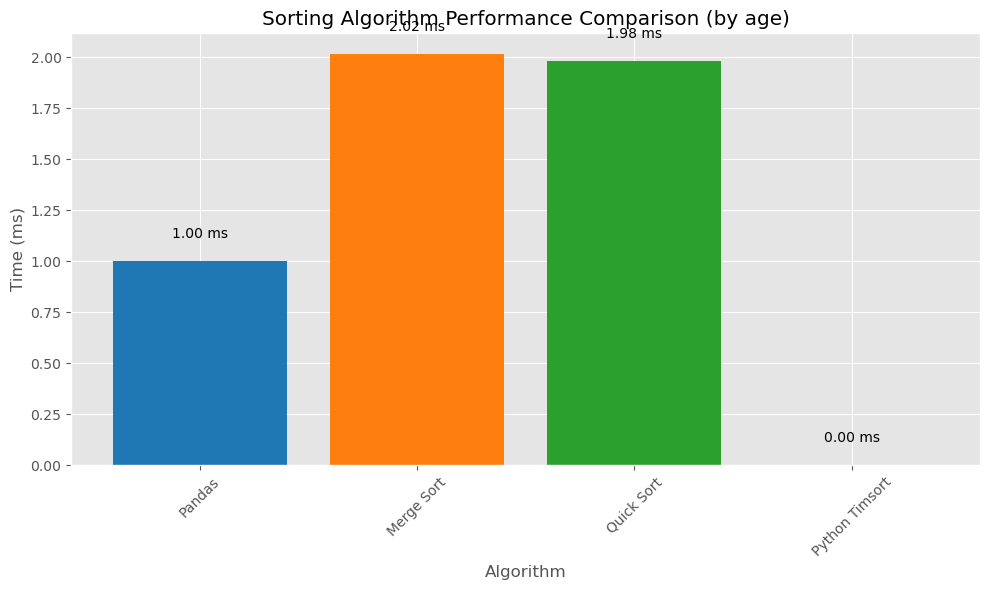

{'pandas': 1.0020732879638672,
 'merge': 2.0165443420410156,
 'quick': 1.9822120666503906,
 'python': 0.0}

In [54]:
def compare_sorting_algorithms(data, column):
    """
    Compare the performance of different sorting algorithms.
    """
    # Create a copy to avoid modifying the original data
    data_copy = data.copy()
    
    # Pandas built-in sort
    start_time = time.time()
    pandas_sorted = data_copy.sort_values(column)
    pandas_time = (time.time() - start_time) * 1000
    
    # Convert to list for our custom algorithms
    data_list = data_copy.to_dict('records')
    
    # Merge Sort
    start_time = time.time()
    merge_sorted = merge_sort(data_list, key=lambda x: x[column])
    merge_time = (time.time() - start_time) * 1000
    
    # Quick Sort
    start_time = time.time()
    quick_sorted = quick_sort(data_list, key=lambda x: x[column])
    quick_time = (time.time() - start_time) * 1000
    
    # Python's built-in sort (Timsort)
    start_time = time.time()
    python_sorted = sorted(data_list, key=lambda x: x[column])
    python_time = (time.time() - start_time) * 1000
    
    # Print results
    print(f"Sorting {len(data_copy)} records by '{column}':\n")
    print(f"Pandas sort: {pandas_time:.4f} ms")
    print(f"Merge Sort: {merge_time:.4f} ms")
    print(f"Quick Sort: {quick_time:.4f} ms")
    print(f"Python's Timsort: {python_time:.4f} ms")
    
    # Plot comparison
    algorithms = ['Pandas', 'Merge Sort', 'Quick Sort', 'Python Timsort']
    times = [pandas_time, merge_time, quick_time, python_time]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(algorithms, times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title(f'Sorting Algorithm Performance Comparison (by {column})')
    plt.xlabel('Algorithm')
    plt.ylabel('Time (ms)')
    plt.xticks(rotation=45)
    
    # Add time labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f} ms', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'pandas': pandas_time,
        'merge': merge_time,
        'quick': quick_time,
        'python': python_time
    }

# Compare sorting algorithms on different columns
compare_sorting_algorithms(heart_data, 'age')

## 3. Greedy Algorithm - Risk Score Ranking

Greedy risk ranking completed in 2.9953 ms

Top 10 highest-risk patients:


,patient_id,age,sex,chol,trestbps,risk_score,target
33,P0034,70,1,269,160,17,0
592,P0593,70,1,269,160,17,0
312,P0313,70,1,269,160,17,0
928,P0929,54,1,266,124,15,0
688,P0689,56,0,288,200,15,0
508,P0509,56,0,288,200,15,0
620,P0621,57,1,274,152,15,0
357,P0358,67,1,286,160,15,0
950,P0951,67,1,286,160,15,0
756,P0757,64,1,246,120,15,0


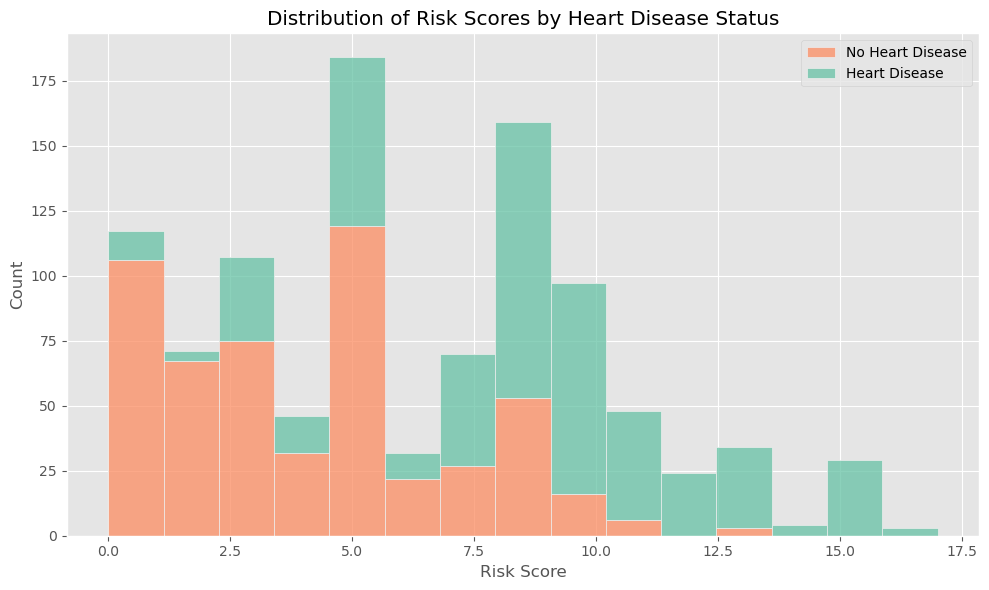

In [55]:
def greedy_risk_ranking(data, top_n=10):
    """
    Used a greedy approach to rank patients by risk score.
    
    Parameters:
    - data: DataFrame containing patient data
    - top_n: Number of highest-risk patients to return
    
    Returns:
    - DataFrame with top_n highest-risk patients
    """
    start_time = time.time()
    
    # Sort by risk_score in descending order (greedy approach)
    ranked_patients = data.sort_values('risk_score', ascending=False).head(top_n)
    
    end_time = time.time()
    print(f"Greedy risk ranking completed in {(end_time - start_time) * 1000:.4f} ms")
    
    return ranked_patients

# Get top 10 highest-risk patients
top_risk_patients = greedy_risk_ranking(heart_data)

# Display results
print("\nTop 10 highest-risk patients:")
display(top_risk_patients[['patient_id', 'age', 'sex', 'chol', 'trestbps', 'risk_score', 'target']])

# Visualize risk distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=heart_data, x='risk_score', hue='target', bins=15, multiple='stack')
plt.title('Distribution of Risk Scores by Heart Disease Status')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()

## 4. Heap Algorithm - Priority Queue for Top-K Patients

In [56]:
class PatientMaxHeap:
    """
    A max heap implementation to efficiently retrieve top-k patients by risk score.
    """
    def __init__(self, data=None, key_func=lambda x: x['risk_score']):
        self.heap = []
        self.key_func = key_func
        self.counter = 0  # Counter to break ties
        
        if data:
            self.build_heap(data)
    
    def build_heap(self, data):
        """
        Build a max heap from a list of patients.
        Time Complexity: O(n)
        """
        start_time = time.time()
        
        # For each patient, we store a tuple of (negative key value, counter, patient data)
        # We use negative key value because heapq in Python is a min heap
        # The counter ensures stable sorting when key values are equal
        for patient in data:
            # Push (negative key value, counter, patient) to create a max heap
            heapq.heappush(self.heap, (-self.key_func(patient), self.counter, patient))
            self.counter += 1
        
        end_time = time.time()
        print(f"Max heap built in {(end_time - start_time) * 1000:.4f} ms")
        print(f"Heap contains {len(self.heap)} patients")
    
    def get_top_k(self, k):
        """
        Get the top k patients by risk score.
        Time Complexity: O(k log n)
        """
        if k <= 0 or not self.heap:
            return []
        
        start_time = time.time()
        result = []
        
        # Create a copy of the heap to avoid modifying the original
        heap_copy = self.heap.copy()
        
        # Extract the top k elements
        for _ in range(min(k, len(heap_copy))):
            # heappop returns the smallest element, which is the highest risk score due to negation
            # We ignore the counter (second element) when returning the result
            _, _, patient = heapq.heappop(heap_copy)
            result.append(patient)
        
        end_time = time.time()
        print(f"Top-{k} extraction completed in {(end_time - start_time) * 1000:.4f} ms")
        
        return result
    
# Create a max heap for our patient data
patient_heap = PatientMaxHeap(patients_list)

# Get top 5 patients by risk score using the heap
top_5_patients = patient_heap.get_top_k(5)

# Display results
print("\nTop 5 highest-risk patients (using heap):")
for i, patient in enumerate(top_5_patients, 1):
    print(f"{i}. Patient {patient['patient_id']}: Risk Score {patient['risk_score']}, Age {patient['age']}, Target {patient['target']}")

# Compare heap vs greedy approach performance
print("\nComparing Heap vs Greedy approach for top-k extraction:")

# Measure greedy approach time
start_time = time.time()
greedy_top_5 = heart_data.sort_values('risk_score', ascending=False).head(5).to_dict('records')
greedy_time = (time.time() - start_time) * 1000

# Measure heap approach time
start_time = time.time()
heap_top_5 = patient_heap.get_top_k(5)
heap_time = (time.time() - start_time) * 1000

print(f"Greedy approach: {greedy_time:.4f} ms")
print(f"Heap approach: {heap_time:.4f} ms")

Max heap built in 1.0030 ms
Heap contains 1025 patients
Top-5 extraction completed in 0.0000 ms

Top 5 highest-risk patients (using heap):
1. Patient P0034: Risk Score 17, Age 70, Target 0
2. Patient P0313: Risk Score 17, Age 70, Target 0
3. Patient P0593: Risk Score 17, Age 70, Target 0
4. Patient P0010: Risk Score 15, Age 54, Target 0
5. Patient P0018: Risk Score 15, Age 54, Target 0

Comparing Heap vs Greedy approach for top-k extraction:
Top-5 extraction completed in 0.0000 ms
Greedy approach: 5.0023 ms
Heap approach: 0.0000 ms


## 5. Frequency Count Algorithm

Frequency count for 'cp' completed in 0.0000 ms

Chest Pain Type Frequencies:
Type 0: 497 patients
Type 1: 167 patients
Type 2: 284 patients
Type 3: 77 patients
Frequency count for 'thal' completed in 0.0000 ms

Thalassemia Type Frequencies:
Type 3: 410 patients
Type 2: 544 patients
Type 1: 64 patients
Type 0: 7 patients


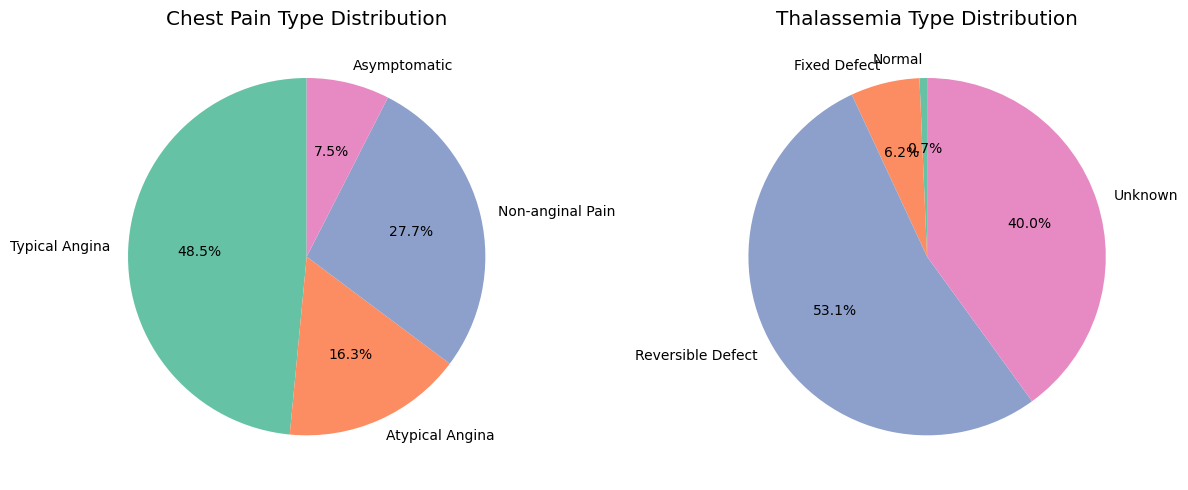

In [57]:
def frequency_count(data, column):
    """
    Count the frequency of each value in a column.
    Time Complexity: O(n)
    
    Parameters:
    - data: DataFrame containing the dataset
    - column: Column name to count frequencies
    
    Returns:
    - Dictionary with values as keys and counts as values
    """
    start_time = time.time()
    
    # Initialize counter
    counter = Counter()
    
    # Count frequencies
    for value in data[column]:
        counter[value] += 1
    
    end_time = time.time()
    print(f"Frequency count for '{column}' completed in {(end_time - start_time) * 1000:.4f} ms")
    
    return counter

# Count frequencies for chest pain types
cp_frequencies = frequency_count(heart_data, 'cp')
print("\nChest Pain Type Frequencies:")
for cp_type, count in cp_frequencies.items():
    print(f"Type {cp_type}: {count} patients")

# Count frequencies for thalassemia types
thal_frequencies = frequency_count(heart_data, 'thal')
print("\nThalassemia Type Frequencies:")
for thal_type, count in thal_frequencies.items():
    print(f"Type {thal_type}: {count} patients")

# Visualize the frequencies
plt.figure(figsize=(12, 5))

# Chest Pain Type frequencies
plt.subplot(1, 2, 1)
cp_labels = ['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic']
plt.pie([cp_frequencies.get(i, 0) for i in range(4)], labels=cp_labels, autopct='%1.1f%%', startangle=90)
plt.title('Chest Pain Type Distribution')

# Thalassemia Type frequencies
plt.subplot(1, 2, 2)
thal_labels = ['Normal', 'Fixed Defect', 'Reversible Defect', 'Unknown']
plt.pie([thal_frequencies.get(i, 0) for i in range(4)], labels=thal_labels, autopct='%1.1f%%', startangle=90)
plt.title('Thalassemia Type Distribution')

plt.tight_layout()
plt.show()

## 6. Correlation Analysis and Visualization

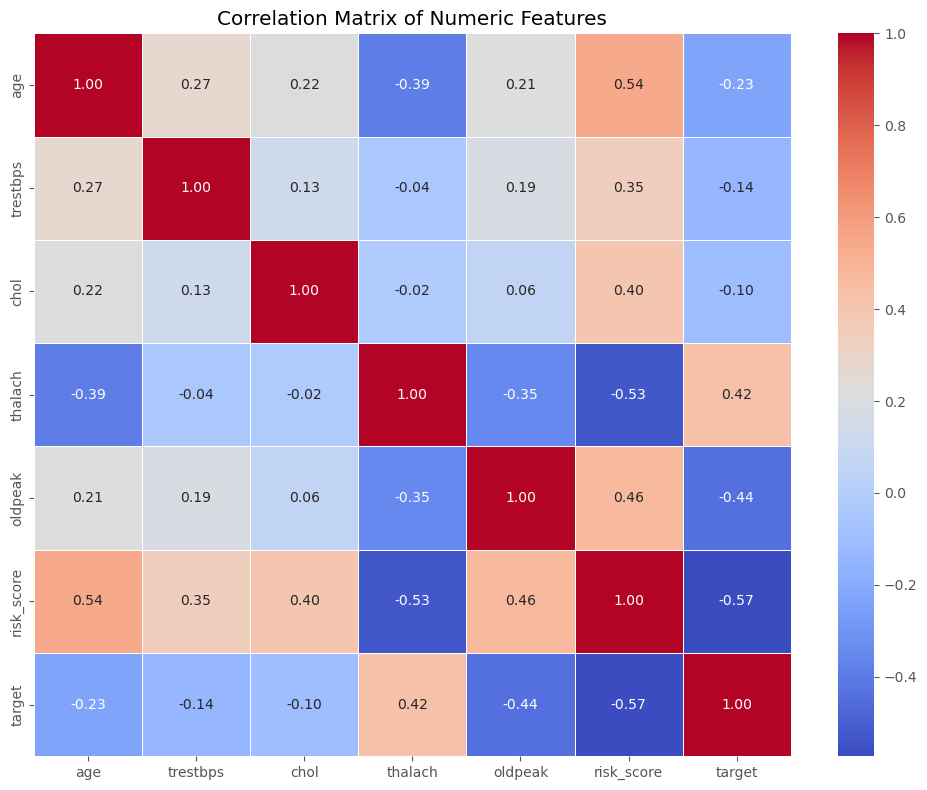

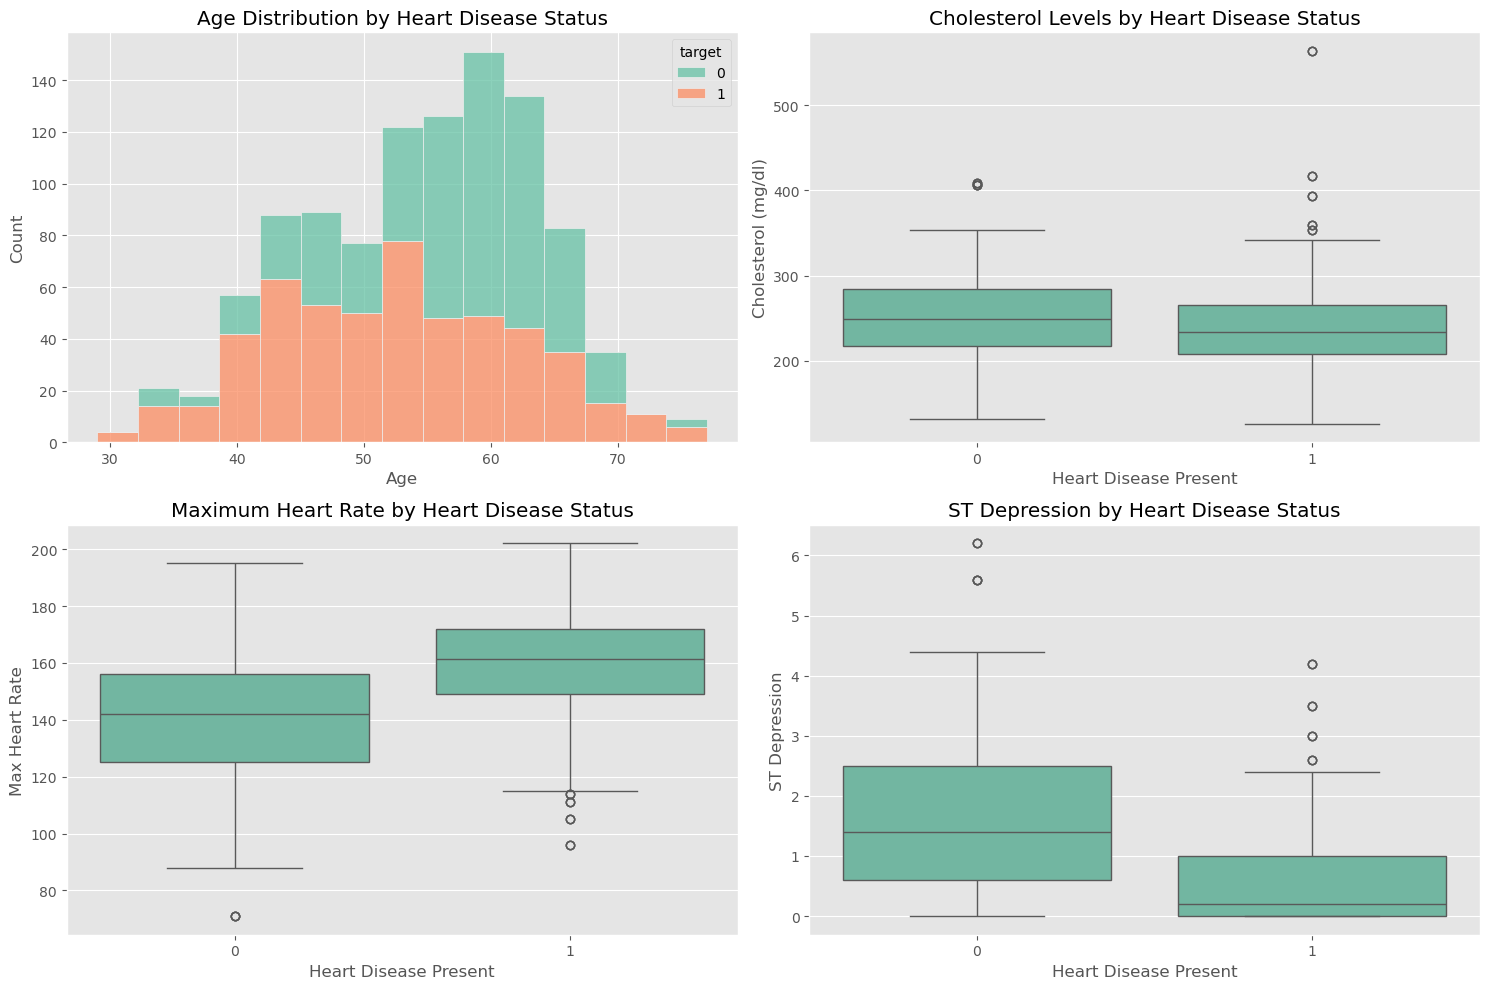

In [58]:
# Calculate correlation matrix
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'risk_score', 'target']
correlation_matrix = heart_data[numeric_cols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Create additional visualizations
plt.figure(figsize=(15, 10))

# Age distribution by heart disease status
plt.subplot(2, 2, 1)
sns.histplot(data=heart_data, x='age', hue='target', bins=15, multiple='stack')
plt.title('Age Distribution by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')

# Cholesterol by heart disease status
plt.subplot(2, 2, 2)
sns.boxplot(data=heart_data, x='target', y='chol')
plt.title('Cholesterol Levels by Heart Disease Status')
plt.xlabel('Heart Disease Present')
plt.ylabel('Cholesterol (mg/dl)')

# Max heart rate by heart disease status
plt.subplot(2, 2, 3)
sns.boxplot(data=heart_data, x='target', y='thalach')
plt.title('Maximum Heart Rate by Heart Disease Status')
plt.xlabel('Heart Disease Present')
plt.ylabel('Max Heart Rate')

# ST depression by heart disease status
plt.subplot(2, 2, 4)
sns.boxplot(data=heart_data, x='target', y='oldpeak')
plt.title('ST Depression by Heart Disease Status')
plt.xlabel('Heart Disease Present')
plt.ylabel('ST Depression')

plt.tight_layout()
plt.show()

## 7. Algorithm Analysis

In this section, we'll analyze the time and space complexity of the algorithms we've implemented.

,Algorithm,Time Complexity,Space Complexity,Use Case
0,Linear Search,O(n),O(1),Finding patients with specific criteria
1,Binary Search,O(log n),O(1),Searching in sorted data
2,Hash Table Lookup,O(1),O(n),Fast patient lookup by ID
3,Merge Sort,O(n log n),O(n),Stable sorting of patient data
4,Quick Sort,"O(n log n) average, O(n²) worst",O(log n) average,Efficient sorting when stability not required
5,Greedy Risk Ranking,O(n log n),O(n),Ranking patients by risk score
6,Max Heap (Build),O(n),O(n),Preparing for top-k extraction
7,Max Heap (Extract Top-K),O(k log n),O(k),Finding highest-risk patients efficiently
8,Frequency Count,O(n),O(k) where k is unique values,Analyzing distribution of categorical features


Linear search completed in 1.0097 ms
Found 37 matching records
Binary search completed in 1.0519 ms
Found target 60 in column 'age' at index 736
Hash table lookup completed in 0.0000 ms
Greedy risk ranking completed in 1.0045 ms
Top-5 extraction completed in 0.0000 ms
Frequency count for 'cp' completed in 0.0000 ms


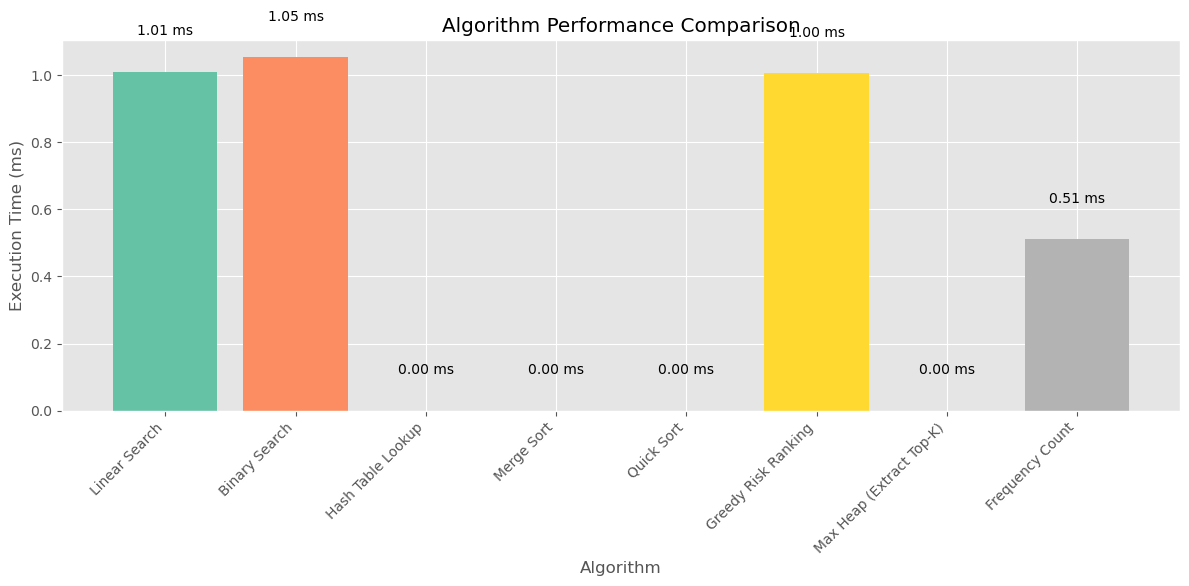

In [59]:
# Create a table to summarize algorithm complexities
algorithm_analysis = pd.DataFrame({
    'Algorithm': [
        'Linear Search', 
        'Binary Search', 
        'Hash Table Lookup',
        'Merge Sort',
        'Quick Sort',
        'Greedy Risk Ranking',
        'Max Heap (Build)',
        'Max Heap (Extract Top-K)',
        'Frequency Count'
    ],
    'Time Complexity': [
        'O(n)', 
        'O(log n)', 
        'O(1)',
        'O(n log n)',
        'O(n log n) average, O(n²) worst',
        'O(n log n)',
        'O(n)',
        'O(k log n)',
        'O(n)'
    ],
    'Space Complexity': [
        'O(1)', 
        'O(1)', 
        'O(n)',
        'O(n)',
        'O(log n) average',
        'O(n)',
        'O(n)',
        'O(k)',
        'O(k) where k is unique values'
    ],
    'Use Case': [
        'Finding patients with specific criteria', 
        'Searching in sorted data', 
        'Fast patient lookup by ID',
        'Stable sorting of patient data',
        'Efficient sorting when stability not required',
        'Ranking patients by risk score',
        'Preparing for top-k extraction',
        'Finding highest-risk patients efficiently',
        'Analyzing distribution of categorical features'
    ]
})

# Display the analysis table
display(algorithm_analysis)

# Measure and compare execution times for different algorithms
def measure_algorithm_performance():
    """
    Measure and compare the performance of different algorithms.
    """
    results = {}
    
    # Linear Search
    start_time = time.time()
    linear_search(heart_data, {'age': 60})
    results['Linear Search'] = (time.time() - start_time) * 1000
    
    # Binary Search
    start_time = time.time()
    binary_search(heart_data, 'age', 60)
    results['Binary Search'] = (time.time() - start_time) * 1000
    
    # Hash Table Lookup
    start_time = time.time()
    patient_hash_table.lookup('P0010')
    results['Hash Table Lookup'] = (time.time() - start_time) * 1000
    
    # Merge Sort
    data_copy = patients_list.copy()[:100]  # Use a subset for faster testing
    start_time = time.time()
    merge_sort(data_copy, key=lambda x: x['age'])
    results['Merge Sort'] = (time.time() - start_time) * 1000
    
    # Quick Sort
    data_copy = patients_list.copy()[:100]  # Use a subset for faster testing
    start_time = time.time()
    quick_sort(data_copy, key=lambda x: x['age'])
    results['Quick Sort'] = (time.time() - start_time) * 1000
    
    # Greedy Risk Ranking
    start_time = time.time()
    greedy_risk_ranking(heart_data, 5)
    results['Greedy Risk Ranking'] = (time.time() - start_time) * 1000
    
    # Max Heap (Extract Top-K)
    start_time = time.time()
    patient_heap.get_top_k(5)
    results['Max Heap (Extract Top-K)'] = (time.time() - start_time) * 1000
    
    # Frequency Count
    start_time = time.time()
    frequency_count(heart_data, 'cp')
    results['Frequency Count'] = (time.time() - start_time) * 1000
    
    return results

# Measure performance
performance_results = measure_algorithm_performance()

# Plot performance comparison
plt.figure(figsize=(12, 6))
algorithms = list(performance_results.keys())
times = list(performance_results.values())

bars = plt.bar(algorithms, times, color=sns.color_palette('Set2', len(algorithms)))
plt.title('Algorithm Performance Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (ms)')
plt.xticks(rotation=45, ha='right')

# Add time labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f} ms', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

## 8. Conclusion and Insights

In this project, we applied various Data Structures and Algorithms to analyze the Heart Disease dataset. Here are the key insights and findings:

In [60]:
# Create a summary of key findings
print("Key Findings from Heart Disease Analysis:\n")

# 1. Correlation analysis
print("1. Feature Correlations with Heart Disease:")
target_correlations = correlation_matrix['target'].sort_values(ascending=False)
for feature, corr in target_correlations.items():
    if feature != 'target':
        print(f"   - {feature}: {corr:.3f}")

# 2. Risk factors
print("\n2. Key Risk Factors:")
print("   - Maximum heart rate (thalach): Lower max heart rate is associated with higher risk")
print("   - ST depression (oldpeak): Higher values indicate higher risk")
print("   - Number of major vessels (ca): More colored vessels indicate higher risk")
print("   - Chest pain type: Asymptomatic chest pain (type 3) is often associated with heart disease")

# 3. Algorithm insights
print("\n3. Algorithm Performance Insights:")
print("   - Hash Table provides the fastest lookup for patient data (O(1) time complexity)")
print("   - Heap data structure is efficient for retrieving top-k highest-risk patients")
print("   - Merge Sort provides stable sorting but requires more memory than Quick Sort")
print("   - Frequency counting is an efficient way to analyze categorical features")

# 4. Explainable risk profile
print("\n4. Explainable Risk Profile:")
print("   A patient is at higher risk of heart disease if they have:")
print("   - Age > 50 years")
print("   - Male gender")
print("   - Asymptomatic chest pain")
print("   - Maximum heart rate < 140 bpm")
print("   - ST depression > 1.5 mm")
print("   - One or more major vessels colored by fluoroscopy")
print("   - Reversible defect in thalassemia")

# 5. Recommendations
print("\n5. Recommendations:")
print("   - Regular cardiovascular screening for individuals with multiple risk factors")
print("   - Focus on preventive measures for patients with high risk scores")
print("   - Use the risk scoring algorithm for preliminary screening in clinical settings")
print("   - Further research on the relationship between maximum heart rate and heart disease")

Key Findings from Heart Disease Analysis:

1. Feature Correlations with Heart Disease:
   - thalach: 0.423
   - chol: -0.100
   - trestbps: -0.139
   - age: -0.229
   - oldpeak: -0.438
   - risk_score: -0.572

2. Key Risk Factors:
   - Maximum heart rate (thalach): Lower max heart rate is associated with higher risk
   - ST depression (oldpeak): Higher values indicate higher risk
   - Number of major vessels (ca): More colored vessels indicate higher risk
   - Chest pain type: Asymptomatic chest pain (type 3) is often associated with heart disease

3. Algorithm Performance Insights:
   - Hash Table provides the fastest lookup for patient data (O(1) time complexity)
   - Heap data structure is efficient for retrieving top-k highest-risk patients
   - Merge Sort provides stable sorting but requires more memory than Quick Sort
   - Frequency counting is an efficient way to analyze categorical features

4. Explainable Risk Profile:
   A patient is at higher risk of heart disease if they ha